1. Augmentation 적용한 데이터 셋 만들기
    
     1.1 데이터 불러오기

     1.2 기본 Augmentation을 적용

     1.3 Cutmix Augmentation

     1.4 Mixup Augmentation

     1.5 데이터 셋 만들기

2. 모델 만들기

3. 모델 훈련하기

4. 훈련과정 시각화 하기

5. Augmentation 성능 비교하기

회고

 - Cutmix Augmentation 학습중 오류가 났는데 왜 발생했는지 잘 모르겠다. 

- Cutmix 와 Mixup 등 여러 Augmentation 기법에 대해 공부할 수 있었다
 

## Augmentation 적용한 데이터 셋 만들기

1.1 데이터 불러오기

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteMFHM4W/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteMFHM4W/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


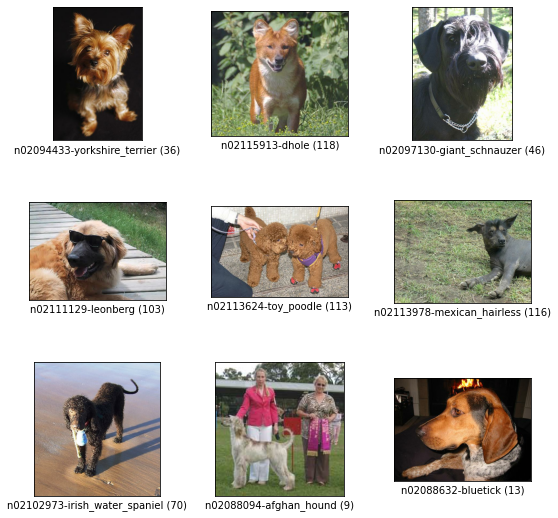

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)  # 다운로드한 데이터 확인

1.2 기본 Augmentation 적용하기

In [ ]:
#  Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만들어 줍니다

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label  # (0 - 1 사이에 픽셀값으로 만들어 준다) 

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)    # 좌우대칭
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 조절
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
# 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다.
# 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠습니다.
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2  # 매개변수를 설정하여 map 변환을 병렬 처리한다. 
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # tf.data 런타임에 가용되는 병렬화 수준 결정
    return ds

- 병렬 매핑: 동일한 전처리 함수를 사용하지만 여러 샘플에 병렬로 적용

    - https://ahnjg.tistory.com/32

    - https://www.tensorflow.org/guide/data_performance?hl=ko

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

1.3 CutMix

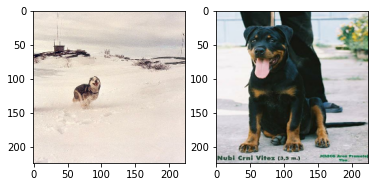

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
# 바탕 이미지 a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)

print('x : ', xa, xb)
print('y : ', ya, yb)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(119, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(145, shape=(), dtype=int32)


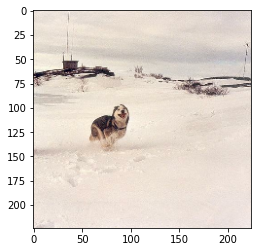

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[ya:yb, 0:xa, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[ya:yb, xa:xb, :]  # image_b의 안쪽 영역
    middle_right = image_a[ya:yb, xa:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:ya, :, :]
    bottom = image_a[yb:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, yb, xa, yb)
plt.imshow(mixed_img.numpy())
plt.show()

In [ ]:
# mix two labels
# 섞인 이미지의 면적에 비례해서 라벨을 섞어주는 함수
def mix_2_labels(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, xa, yb, xa, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>

In [ ]:
# 위에서 구현한 두 함수를 활용하여 배치 단위의 cutmix() 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, yb, xa, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_labels(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

1.4 Mixup

In [ ]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

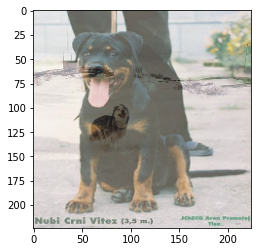

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.60064924
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.3

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

1.5 데이터셋 만들기

In [ ]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
# 배치 단위로 데이터셋을 정렬 후 cutmix와 mixup을 적용할 수 있도록 수정한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False,with_cutmix=False, with_mixup=False):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )
  if not is_test and with_aug:
      ds = ds.map(
          augment
      )
  ds = ds.batch(batch_size)
  if not is_test and with_cutmix:
      ds = ds.map(
          cutmix,
          num_parallel_calls=2
      )
  elif not is_test and with_mixup:
      ds = ds.map(
          mixup,
          num_parallel_calls=2
      )
  else:
      ds = ds.map(
          onehot,
          num_parallel_calls=2
      )
  if not is_test:
      ds = ds.repeat()
      ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2. 모델 만들기

- include_top=False :  맨 위에 분류 층이 포함되지 않은 네트워크를 로드하므로 특징 추출에 이상적이다
- transfer learning과 유사하게 보일 수도 있지만 pre training된 weight을 내려받어 통과시킨 feature을 그대로 사용하면서 학습시 fully connected계층만 트레이닝 시키는 transfer learning 과는 다르다.

출처: https://rarena.tistory.com/42 [deep dev]

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

In [ ]:
# 비교실험 하기
# Augmentation 적용 안 한 데이터셋으로 학습시킬 ResNet50
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,  # 마지막 fully connected layer 미포함.
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

94781440/94765736 [==============================] - 1s 0us/step
=3


In [ ]:
# Augmentation 적용한 데이터셋으로 학습시킬 ResNet50
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

=3


In [ ]:
# cutmix 사용
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

=3


In [ ]:
# mixup 사용
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

=3


## 3. 모델 훈련하기
- cutmix, mixup을 구현하면서 lable 의 mix 때문에 더이상 label 이 스칼라 값을 가지지 못하고 one-hot 벡터 형태로 변환되었기 때문에 spars_categorycal_crossentropy() 대신 categorical_crossentropy 를 사용해야 한다.

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 178s 210ms/step - loss: 2.2060 - accuracy: 0.4420 - val_loss: 3.1982 - val_accuracy: 0.2389
Epoch 2/20
750/750 [==============================] - 161s 215ms/step - loss: 0.7611 - accuracy: 0.7840 - val_loss: 1.0989 - val_accuracy: 0.6758
Epoch 3/20
750/750 [==============================] - 161s 215ms/step - loss: 0.2411 - accuracy: 0.9479 - val_loss: 0.9453 - val_accuracy: 0.7210
Epoch 4/20
750/750 [==============================] - 163s 217ms/step - loss: 0.0646 - accuracy: 0.9940 - val_loss: 0.9132 - val_accuracy: 0.7375
Epoch 5/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0256 - accuracy: 0.9988 - val_loss: 0.8989 - val_accuracy: 0.7481
Epoch 6/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0137 - accuracy: 0.9999 - val_loss: 0.9076 - val_accuracy: 0.7467
Epoch 7/20
750/750 [==============================] - 162s 215ms/step - loss: 0.0094 - accuracy: 0.9999 - val_loss: 0.9200 -

In [ ]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 172s 217ms/step - loss: 2.2943 - accuracy: 0.4270 - val_loss: 3.0639 - val_accuracy: 0.2547
Epoch 2/20
750/750 [==============================] - 161s 215ms/step - loss: 0.9934 - accuracy: 0.7135 - val_loss: 1.2496 - val_accuracy: 0.6354
Epoch 3/20
750/750 [==============================] - 161s 215ms/step - loss: 0.5252 - accuracy: 0.8525 - val_loss: 1.0562 - val_accuracy: 0.6897
Epoch 4/20
750/750 [==============================] - 161s 215ms/step - loss: 0.2916 - accuracy: 0.9301 - val_loss: 1.3783 - val_accuracy: 0.6290
Epoch 5/20
750/750 [==============================] - 162s 216ms/step - loss: 0.1599 - accuracy: 0.9659 - val_loss: 0.9693 - val_accuracy: 0.7204
Epoch 6/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0817 - accuracy: 0.9874 - val_loss: 0.9742 - val_accuracy: 0.7282
Epoch 7/20
750/750 [==============================] - 162s 216ms/step - loss: 0.0481 - accuracy: 0.9939 - val_loss: 0.9824 -

In [ ]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    )

Epoch 1/20


InvalidArgumentError: ignored

- use_multiprocessing=True 자리가 빨간줄 쳐지며 InvalidArgumentError: Graph execution error: 가 떴다..
- use_multiprocessing=True 는 fit_generator 에 

https://github.com/kec0130/AIFFEL-project/blob/main/goingdeeper/G4_data_augmentation_pjt.ipynb 
여기 들어가서 다시 공부 해


In [ ]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

## 4. 훈련 과정 시각화하기

In [ ]:
# 훈련 과정을 시각화
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','With CutMix','With Mixup'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper right')
plt.grid(True)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

In [ ]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'],
            'With Augmentation': history_resnet50_aug.history['val_accuracy'],
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'],
            'With Mixup': history_resnet50_mixup.history['val_accuracy']}
acc_df = dp.DataFrame(acc_data)
acc_df

In [ ]:
acc_df.describe()

회고 

코드참고 https://github.com/kec0130/AIFFEL-project/blob/main/goingdeeper/G4_data_augmentation_pjt.ipynb